In [1]:
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymongo
import seaborn as sns
import humanize
import warnings
import os

In [2]:
warnings.filterwarnings('ignore')

load_dotenv()

True

In [3]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80

In [4]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

apartments.head(3)

,codigo,tipo_propiedad,tipo_operacion,precio_venta,precio_arriendo,area,habitaciones,banos,administracion,parqueaderos,...,permite_mascotas,gimnasio,ascensor,conjunto_cerrado,coords_modified,localidad,barrio,estacion_tm_cercana,distancia_estacion_tm_m,is_cerca_estacion_tm
1,2510-M4156145,APARTAMENTO,VENTA,4.850000e+08,NaN,84.0,3.0,3.0,680000.0,1.0,...,0.0,0.0,1.0,1.0,False,USAQUEN,SAN PATRICIO,Pepe Sierra,1116.77,0
3,10139-M4343016,APARTAMENTO,VENTA,4.850000e+08,NaN,77.2,3.0,2.0,367000.0,1.0,...,1.0,1.0,1.0,1.0,False,SUBA,CAMPOS DE SILENCIO,Calle 161,933.85,0
4,10139-M3692828,APARTAMENTO,VENTA,1.570000e+09,NaN,213.0,3.0,4.0,994000.0,3.0,...,0.0,1.0,1.0,1.0,False,USAQUEN,GINEBRA,Prado,2769.19,0


In [5]:
# apartments = pd.read_csv('../data/processed/apartments.csv')
# print(apartments.shape)
# apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]
# apartments = apartments.drop(['precio_arriendo'], axis=1)
# apartments.head()

In [6]:
apartments.shape

(54500, 40)

In [7]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54500 entries, 1 to 84819
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   codigo                               54500 non-null  object 
 1   tipo_propiedad                       54500 non-null  object 
 2   tipo_operacion                       54500 non-null  object 
 3   precio_venta                         54500 non-null  float64
 4   precio_arriendo                      241 non-null    float64
 5   area                                 54499 non-null  float64
 6   habitaciones                         54497 non-null  float64
 7   banos                                54497 non-null  float64
 8   administracion                       49284 non-null  float64
 9   parqueaderos                         54497 non-null  float64
 10  sector                               51780 non-null  object 
 11  estrato                          

In [8]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta',
       'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'sector', 'estrato', 'antiguedad', 'estado', 'longitud',
       'latitud', 'descripcion', 'datetime', 'website', 'compañia',
       'last_view', 'fecha_actualizacion_precio_venta',
       'precio_venta_anterior', 'fecha_actualizacion_precio_arriendo',
       'precio_arriendo_anterior', 'direccion', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'coords_modified', 'localidad', 'barrio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm'],
      dtype='object')

In [9]:
apartments['datetime'] = pd.to_datetime(apartments['datetime'])

In [10]:
fotmat_tick_humanize = lambda x, pos: humanize.intword(x)

# Elimindando Outliers

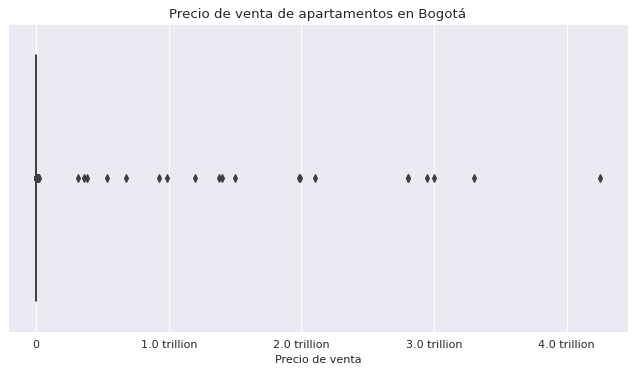

In [11]:
plt.figure(figsize=(10, 5))

sns.boxplot(x='precio_venta', data=apartments)
plt.title('Precio de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))

In [12]:
Q1 = apartments['precio_venta'].quantile(0.25)
Q3 = apartments['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.8 * IQR
upper = Q3 + 1.8 * IQR

if lower < 0:
    lower = Q1 - 0.4 * IQR

outliers = apartments.loc[(apartments['precio_venta'] < lower) | (apartments['precio_venta'] > upper)]
outliers.shape
# lower, upper

(3162, 40)

In [13]:
apartments = apartments[(apartments['precio_venta'] > lower) & (apartments['precio_venta'] < upper)]
apartments.shape

(51338, 40)

# Analisis Univariado

In [14]:
# selecionar todos los meses de datetime
apartments['month'] = apartments['datetime'].dt.month

In [15]:
apartments['month_name'] = apartments['month'].replace({1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 5:'Mayo', 6:'Junio',
                                   7:'Julio', 8:'Agosto', 9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'})

In [16]:
apartments['month_name'].value_counts()

month_name
Junio         18837
Agosto        11036
Julio          8035
Noviembre      4836
Octubre        4601
Septiembre     2699
Diciembre      1294
Name: count, dtype: int64

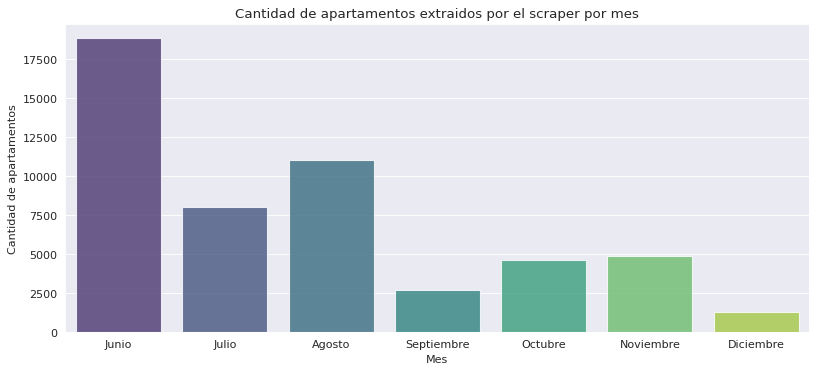

In [17]:
plt.figure(figsize=(12, 5))

sns.countplot(
    x='month_name', 
    data=apartments,
    palette='viridis',
    alpha=.8,
    # ordenar por el mes
    order=['Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
)

plt.title('Cantidad de apartamentos extraidos por el scraper por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de apartamentos')
plt.savefig('../visualizations/apartments_by_month.png', bbox_inches='tight')
plt.show()

In [18]:
apartments['localidad'].value_counts()

localidad
USAQUEN               19476
CHAPINERO             10609
SUBA                  10083
KENNEDY                2421
FONTIBON               1981
ENGATIVA               1773
TEUSAQUILLO            1566
BOSA                    756
SANTA FE                748
CIUDAD BOLIVAR          395
BARRIOS UNIDOS          334
PUENTE ARANDA           281
LOS MARTIRES            239
USME                    162
RAFAEL URIBE URIBE      150
CANDELARIA              105
ANTONIO NARINO          104
SAN CRISTOBAL           102
TUNJUELITO               53
Name: count, dtype: int64

## Actualizacion de datos

In [19]:
import calendar

apartments['fecha_actualizacion_precio_venta'] = pd.to_datetime(apartments['fecha_actualizacion_precio_venta'])
apartments['mes_actualizacion_precio_venta'] = apartments['fecha_actualizacion_precio_venta'].dt.month.fillna(0).astype(int)
apartments['mes_actualizacion_precio_venta'] = apartments['mes_actualizacion_precio_venta'].apply(lambda x: calendar.month_abbr[x])
apartments['mes_actualizacion_precio_venta'].value_counts()

mes_actualizacion_precio_venta
       47477
Oct     1031
Nov      823
Aug      631
Sep      593
Dec      469
Jul      314
Name: count, dtype: int64

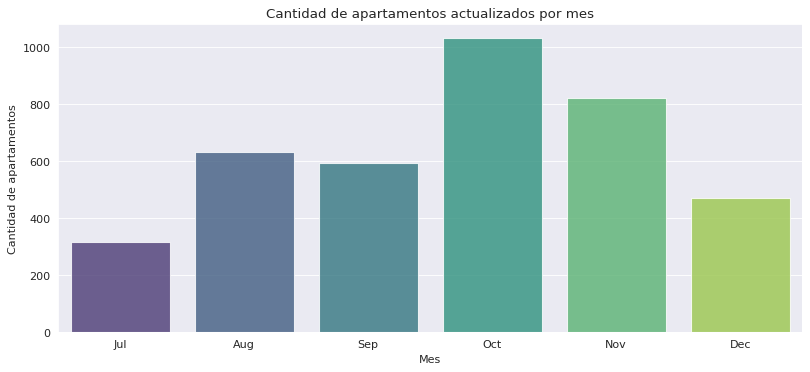

In [40]:
plt.figure(figsize=(12, 5))

sns.countplot(
    x=apartments['mes_actualizacion_precio_venta'].loc[apartments['mes_actualizacion_precio_venta'] != ''],
    # data=apartments,
    palette='viridis',
    alpha=.8,
    order=['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
)

plt.title('Cantidad de apartamentos actualizados por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de apartamentos')
plt.savefig('../visualizations/apartments_by_month_updated.png', bbox_inches='tight')
plt.show()

## Precio de Venta

In [21]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,"51,338.0","717,751,002.3807122","513,462,998.58448064","59,000,000.0","345,000,000.0","550,000,000.0","950,000,000.0","2,440,000,000.0"


In [22]:
apartments['precio_venta'].describe().apply(lambda x: humanize.intword(x)).to_frame().T

,count,mean,std,min,25%,50%,75%,max
precio_venta,51.3 thousand,717.8 million,513.5 million,59.0 million,345.0 million,550.0 million,950.0 million,2.4 billion


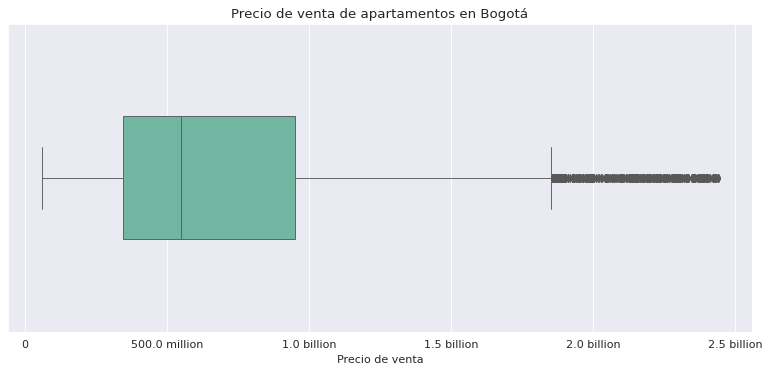

In [23]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.show()

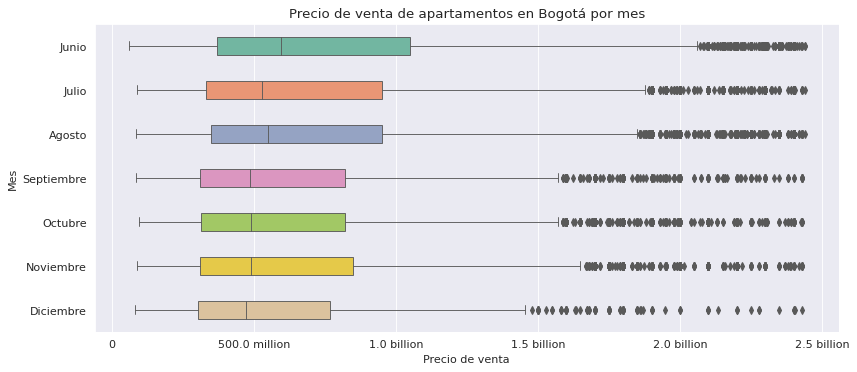

In [24]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=apartments,
    x='precio_venta',
    y='month_name',
    width=.4,
    palette='Set2',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Bogotá por mes')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xlabel('Precio de venta')
plt.ylabel('Mes')
plt.show()

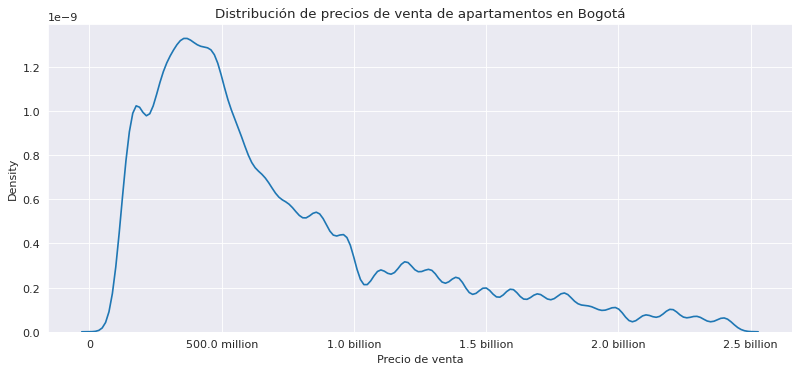

In [25]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [26]:
stat, p = stats.normaltest(apartments['precio_venta'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=9115.112, p=0.000


In [27]:
alpha = 0.05
if p > alpha:
    print('La muestra parece Gaussiana (no rechazar H0)')
else:
    print('La muestra no parece Gaussiana (rechazar H0)')

La muestra no parece Gaussiana (rechazar H0)


In [28]:
apartments['is_cerca_estacion_tm'].value_counts()

is_cerca_estacion_tm
0    40692
1    10646
Name: count, dtype: int64

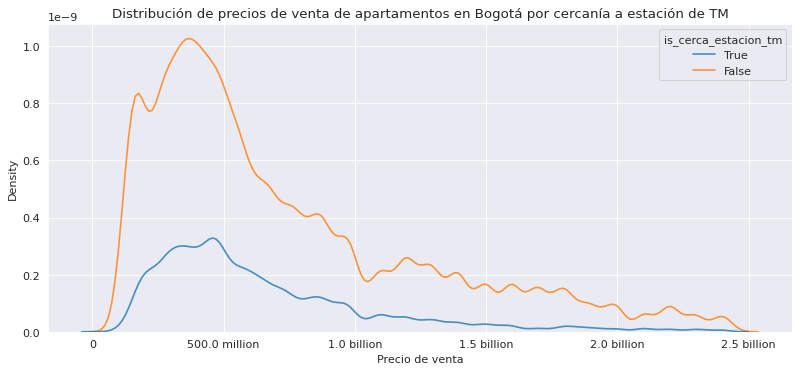

In [29]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    data=apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    bw_adjust=.5,
    hue_order=[True, False],
    alpha=.8,
)

plt.title('Distribución de precios de venta de apartamentos en Bogotá por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

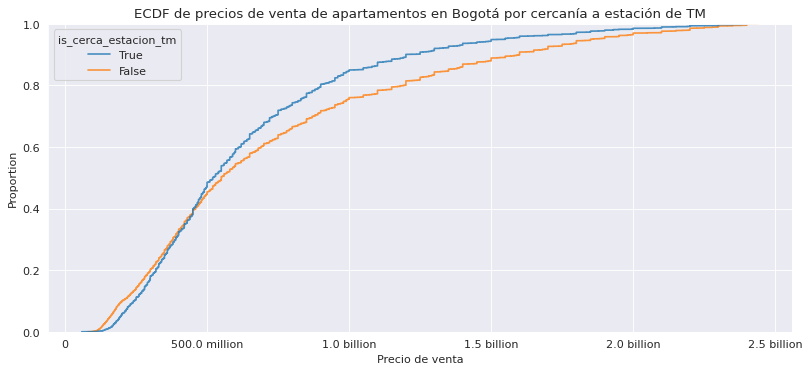

In [30]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    apartments,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    alpha=.8,
)

plt.title('ECDF de precios de venta de apartamentos en Bogotá por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [31]:
# stats de precio por cada mes
stats_month = apartments.groupby('month_name')['precio_venta'].describe()
stats_month

,count,mean,std,min,25%,50%,75%,max
month_name,,,,,,,,
Agosto,11036.0,7.294882e+08,5.196718e+08,84000000.0,350000000.0,550000000.0,9.500000e+08,2.440000e+09
Diciembre,1294.0,6.042519e+08,4.315330e+08,82600000.0,305000000.0,473500000.0,7.687500e+08,2.430000e+09
Julio,8035.0,7.075723e+08,5.146084e+08,90000000.0,330000000.0,530000000.0,9.500000e+08,2.440000e+09
Junio,18837.0,7.672160e+08,5.276702e+08,59000000.0,371000000.0,595000000.0,1.050000e+09,2.440000e+09
Noviembre,4836.0,6.558882e+08,4.839688e+08,88900000.0,310000000.0,490500000.0,8.500000e+08,2.430000e+09
Octubre,4601.0,6.461889e+08,4.776390e+08,96000000.0,313000000.0,490000000.0,8.200000e+08,2.430000e+09
Septiembre,2699.0,6.420842e+08,4.859290e+08,85000000.0,310000000.0,485000000.0,8.200000e+08,2.430000e+09


In [32]:
# stats de precio por localidad

stats_localidad = apartments.groupby('localidad')['precio_venta'].describe()
stats_localidad.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
localidad,,,,,,,,
CHAPINERO,10609.0,1.149171e+09,5.784809e+08,150000000.0,665000000.0,1.050000e+09,1.600000e+09,2.440000e+09
USAQUEN,19476.0,7.792567e+08,4.617953e+08,59000000.0,430000000.0,6.400000e+08,9.950000e+08,2.400000e+09
SUBA,10083.0,5.541898e+08,3.629159e+08,102000000.0,315000000.0,4.565000e+08,6.650000e+08,2.400000e+09
TEUSAQUILLO,1566.0,5.524164e+08,2.647768e+08,124000000.0,395000000.0,5.000000e+08,6.500000e+08,2.200000e+09
SANTA FE,748.0,4.765593e+08,2.553603e+08,100400000.0,320000000.0,4.300000e+08,5.825000e+08,2.400000e+09
FONTIBON,1981.0,4.611402e+08,3.206912e+08,113200000.0,250000000.0,3.800000e+08,5.500000e+08,2.400000e+09
BARRIOS UNIDOS,334.0,4.383803e+08,1.414147e+08,165000000.0,332375000.0,4.200000e+08,5.150000e+08,1.200000e+09
CANDELARIA,105.0,3.978606e+08,1.722101e+08,108000000.0,260000000.0,3.800000e+08,4.600000e+08,9.100000e+08
PUENTE ARANDA,281.0,3.739285e+08,2.487679e+08,103500000.0,230000000.0,3.200000e+08,4.300000e+08,2.328144e+09


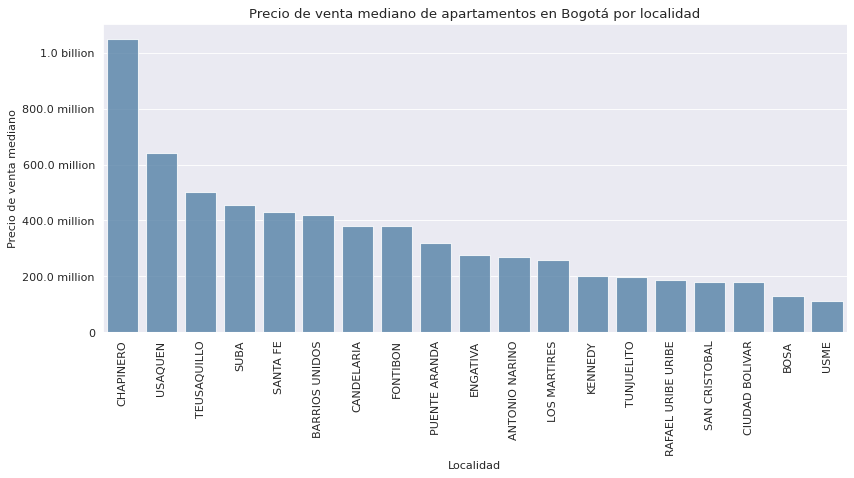

In [33]:
plt.figure(figsize=(12, 5))

sns.barplot(
    x=stats_localidad.index,
    y=stats_localidad['50%'],
    alpha=.8,
    order=stats_localidad.sort_values(by='50%', ascending=False).index,
    color='steelblue',
)

plt.title('Precio de venta mediano de apartamentos en Bogotá por localidad')
plt.xlabel('Localidad')
plt.ylabel('Precio de venta mediano')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.xticks(rotation=90)
plt.show()

In [34]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta',
       'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'sector', 'estrato', 'antiguedad', 'estado', 'longitud',
       'latitud', 'descripcion', 'datetime', 'website', 'compañia',
       'last_view', 'fecha_actualizacion_precio_venta',
       'precio_venta_anterior', 'fecha_actualizacion_precio_arriendo',
       'precio_arriendo_anterior', 'direccion', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'coords_modified', 'localidad', 'barrio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm', 'month', 'month_name',
       'mes_actualizacion_precio_venta'],
      dtype='object')

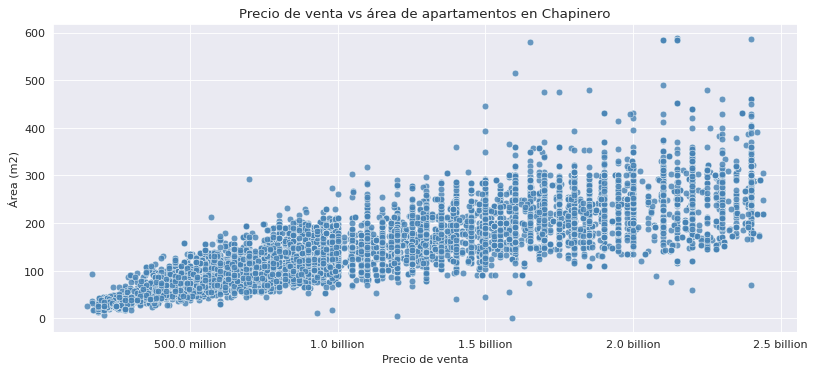

In [35]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    data=apartments.loc[apartments['localidad'] == 'CHAPINERO'],
    x='precio_venta',
    y=apartments['area'].loc[(apartments['localidad'] == 'CHAPINERO') & (apartments['area'] < 800) & (apartments['area'] > 0)],
    alpha=.8,
    color='steelblue',
)

plt.title('Precio de venta vs área de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.ylabel('Área (m2)')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(fotmat_tick_humanize))
plt.show()

In [36]:
apartments.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta',
       'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'sector', 'estrato', 'antiguedad', 'estado', 'longitud',
       'latitud', 'descripcion', 'datetime', 'website', 'compañia',
       'last_view', 'fecha_actualizacion_precio_venta',
       'precio_venta_anterior', 'fecha_actualizacion_precio_arriendo',
       'precio_arriendo_anterior', 'direccion', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'coords_modified', 'localidad', 'barrio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm', 'month', 'month_name',
       'mes_actualizacion_precio_venta'],
      dtype='object')

In [37]:
apartments['last_view'] = pd.to_datetime(apartments['last_view'])

apartments['last_view'].dt.month.value_counts()

last_view
11.0    14902
12.0     9170
10.0     7815
9.0       845
Name: count, dtype: int64

In [42]:
apartments.website.value_counts()

website
metrocuadrado.com    49816
habi.co               1522
Name: count, dtype: int64